# Connect4 dataset viewer

This notebook documents the two datasets in `final_data/`:

- `vanilla_mcts.npz`: dataset generated from vanilla MCTS.
- `guided_mcts.npz`: dataset generated from CNN-guided MCTS.

Each dataset contains:

- `boards`: 6x7 grid with +1 (to-move), -1 (opponent), 0 (empty)
- `X`: 6x7x2 encoding (channel 0 = to-move, channel 1 = opponent)
- `visits`: raw MCTS visit counts per column (length 7)
- `scores`: raw MCTS net scores per column (length 7)
- `policy`: normalized visits (length 7)
- `q`: per-move expected outcome (length 7)
- `value`: expected outcome for the board (length 1)

We will load the files, inspect shapes, show full examples with visual boards,
show how to mirror a dataset, and describe how to train and run a two-headed
policy/value CNN.


## Data sources (tunables)

Update these paths/URLs when your data moves (local file paths or GitHub release links).


In [1]:
from pathlib import Path
import urllib.request
import tempfile

# Data sources can be local paths OR direct URLs to .npz files.
VANILLA_NPZ = "https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/vanilla_mcts_not_mirrored_200_3000.npz"
GUIDED_NPZ = "https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/guided_mcts_mirrored_500_3000.npz"


def load_npz(source):
    # Load from local path or download URL to a temp file.
    if str(source).startswith("http://") or str(source).startswith("https://"):
        tmp_dir = Path(tempfile.gettempdir())
        tmp_path = tmp_dir / Path(str(source)).name
        if not tmp_path.exists():
            urllib.request.urlretrieve(str(source), tmp_path)
        return np.load(tmp_path)
    return np.load(Path(source))


## Load the datasets

This block loads the two `.npz` files and stores them in a dictionary so we can
reference them consistently. We keep the paths explicit to avoid accidental
mixups.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load datasets using the tunables above.
npz = {
    "vanilla": load_npz(VANILLA_NPZ),
    "guided": load_npz(GUIDED_NPZ),
}
print("Loaded vanilla:", VANILLA_NPZ)
print("Loaded guided:", GUIDED_NPZ)


Loaded vanilla: https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/vanilla_mcts_not_mirrored_200_3000.npz
Loaded guided: https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/guided_mcts_mirrored_500_3000.npz


## Quick dataset summary

This block prints the number of boards and the shapes of each stored array. It is
useful for confirming that all required fields are present and consistent.


In [8]:
for name, data in npz.items():
    print("Dataset:", name)
    print("boards:", data["boards"].shape)
    print("X:", data["X"].shape)
    print("visits:", data["visits"].shape)
    print("scores:", data["scores"].shape)
    print("policy:", data["policy"].shape)
    print("q:", data["q"].shape)
    print("value:", data["value"].shape)
    print(f'\n')


Dataset: vanilla
boards: (610112, 6, 7)
X: (610112, 6, 7, 2)
visits: (610112, 7)
scores: (610112, 7)
policy: (610112, 7)
q: (610112, 7)
value: (610112, 1)


Dataset: guided
boards: (932264, 6, 7)
X: (932264, 6, 7, 2)
visits: (932264, 7)
scores: (932264, 7)
policy: (932264, 7)
q: (932264, 7)
value: (932264, 1)




## Visualize a board

We render the 6x7 board so it is easy to see where the current player (+1) and
opponent (-1) pieces are. This is purely a visualization helper; it does not
change any data.


In [9]:
def plot_board(board, title=None):
    # Map: -1 (opponent) -> red, 0 -> white, +1 (to-move) -> blue.
    cmap = plt.cm.get_cmap("bwr", 3)
    plt.figure(figsize=(4, 3))
    plt.imshow(board, cmap=cmap, vmin=-1, vmax=1)
    plt.xticks(range(7))
    plt.yticks(range(6))
    plt.grid(True, color="black", linewidth=0.5)
    if title:
        plt.title(title)
    plt.show()


## Full random examples (three from each dataset)

This block prints **everything** for three random rows from each dataset:

- `board` (raw 6x7)
- `X` shape and channel sums
- `visits`, `scores`, `policy`, `q`, `value`
- A visual board plot

This is a sanity check that the data is internally consistent.


=== Random samples from vanilla ===
Sample 1 (index 576497)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0]
 [ 0  0  0  0  0 -1  0]
 [ 0  1  0  1  0  1  0]
 [ 0 -1  0 -1  0  1  1]
 [-1 -1 -1  1  1  1 -1]]
X shape: (6, 7, 2)
X channel0 sum: 8.0 channel1 sum: 8.0
visits: [48. 19. 49. 15. 19. 17. 33.]
scores: [ 6. -7.  3. -7. -7. -7. -3.]
policy: [0.24  0.095 0.245 0.075 0.095 0.085 0.165]
q: [ 0.125      -0.36842105  0.06122449 -0.46666667 -0.36842105 -0.4117647
 -0.09090909]
value: [-0.11]


/tmp/ipython-input-490388798.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("bwr", 3)


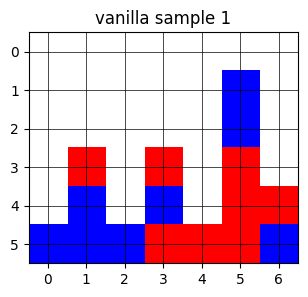

Sample 2 (index 381378)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0 -1  0 -1  1  0  0]
 [ 1 -1  1  1 -1  0  0]
 [-1  1 -1 -1 -1  1  0]
 [-1 -1  1  1 -1  1  0]]
X shape: (6, 7, 2)
X channel0 sum: 10.0 channel1 sum: 11.0
visits: [37. 15. 24. 49. 12. 51. 12.]
scores: [ 3. -5. -2.  9. -6. 15. -6.]
policy: [0.185 0.075 0.12  0.245 0.06  0.255 0.06 ]
q: [ 0.08108108 -0.33333334 -0.08333334  0.18367347 -0.5         0.29411766
 -0.5       ]
value: [0.04]


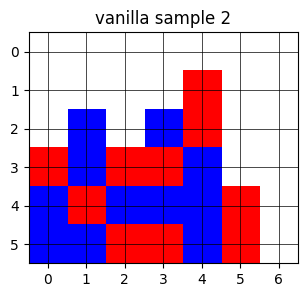

Sample 3 (index 417426)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0]
 [ 0  0  1 -1 -1  0  0]
 [ 0  1 -1 -1 -1  1 -1]]
X shape: (6, 7, 2)
X channel0 sum: 5.0 channel1 sum: 6.0
visits: [24. 14. 57. 24. 27. 35. 19.]
scores: [ 8.  0. 37.  8. 10. 17.  5.]
policy: [0.12  0.07  0.285 0.12  0.135 0.175 0.095]
q: [0.33333334 0.         0.64912283 0.33333334 0.37037036 0.4857143
 0.2631579 ]
value: [0.425]


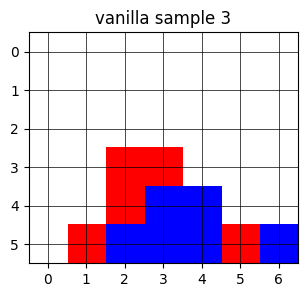

=== Random samples from guided ===
Sample 1 (index 836440)
board: [[ 0 -1  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 0 -1  0  0 -1  0  1]
 [ 1  1 -1  1  1 -1 -1]
 [ 1 -1  1  1 -1 -1  1]]
X shape: (6, 7, 2)
X channel0 sum: 10.0 channel1 sum: 10.0
visits: [ 12.   0. 112.  20. 210.  20.  25.]
scores: [ 7.1768494  0.        16.819187   8.988268  18.653067   6.6847405
  6.2378507]
policy: [0.03007519 0.         0.28070176 0.05012531 0.5263158  0.05012531
 0.06265664]
q: [0.5980708  0.         0.15017131 0.4494134  0.08882412 0.33423704
 0.24951403]
value: [0.16180442]


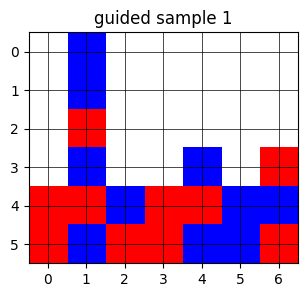

Sample 2 (index 539121)
board: [[-1  0 -1  0  0  0  0]
 [ 1  0  1  0  0  0  0]
 [-1  0 -1  0  0  0  0]
 [ 1  0  1  0  0  1  0]
 [ 1  0  1  0  1 -1 -1]
 [-1  0 -1  0  1 -1 -1]]
X shape: (6, 7, 2)
X channel0 sum: 9.0 channel1 sum: 10.0
visits: [  0.  22.   0.  24.  20. 130. 203.]
scores: [ 0.       10.111675  0.       11.55349  10.083846 16.581123 42.56642 ]
policy: [0.         0.05513784 0.         0.06015038 0.05012531 0.32581455
 0.50877196]
q: [0.        0.4596216 0.        0.4813954 0.5041923 0.1275471 0.2096868]
value: [0.22781093]


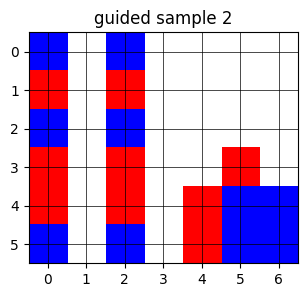

Sample 3 (index 723143)
board: [[-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 1  0  1  0  0  1  0]
 [-1  0  1  0  0  1  0]
 [ 1  0 -1 -1  0  1 -1]
 [-1  1  1 -1 -1 -1  1]]
X shape: (6, 7, 2)
X channel0 sum: 10.0 channel1 sum: 10.0
visits: [0. 0. 0. 0. 0. 1. 0.]
scores: [0. 0. 0. 0. 0. 1. 0.]
policy: [0. 0. 0. 0. 0. 1. 0.]
q: [0. 0. 0. 0. 0. 1. 0.]
value: [1.]


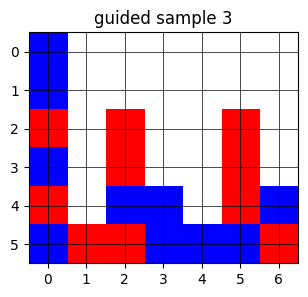

In [11]:
rng = np.random.default_rng(7)

for name, data in npz.items():
    print("=== Random samples from", name, "===")
    n = data["boards"].shape[0]
    for i in range(3):
        idx = int(rng.integers(0, n))
        board = data["boards"][idx]
        X = data["X"][idx]
        visits = data["visits"][idx]
        scores = data["scores"][idx]
        policy = data["policy"][idx]
        q = data["q"][idx]
        value = data["value"][idx]

        print(f"Sample {i+1} (index {idx})")
        print("board:", board)
        print("X shape:", X.shape)
        print("X channel0 sum:", float(X[:, :, 0].sum()), "channel1 sum:", float(X[:, :, 1].sum()))
        print("visits:", visits)
        print("scores:", scores)
        print("policy:", policy)
        print("q:", q)
        print("value:", value)

        plot_board(board, title=f"{name} sample {i+1}")


## Mirror a dataset (for symmetry augmentation)

This block shows how to mirror boards left-to-right and merge duplicates.

- Boards are mirrored by flipping columns.
- Policy, visits, and scores are mirrored by reversing the 7-column vectors.
- When a mirrored board already exists, we **merge** by summing visits/scores
  and averaging policy/value.

This produces a symmetry-augmented dataset without changing the meaning of the
labels.


In [12]:
def mirror_dataset(data):
    boards = data["boards"]
    X = data["X"]
    policy = data["policy"]
    visits = data["visits"]
    scores = data["scores"]
    value = data["value"]

    merged = {}

    def add_entry(b, x, p, v, sc, val):
        key = tuple(b.ravel())
        if key not in merged:
            merged[key] = {
                "board": b,
                "X": x,
                "policy_sum": p.copy(),
                "visits_sum": v.copy(),
                "scores_sum": sc.copy(),
                "value_sum": val.copy(),
                "count": 1,
            }
            return
        merged[key]["policy_sum"] += p
        merged[key]["visits_sum"] += v
        merged[key]["scores_sum"] += sc
        merged[key]["value_sum"] += val
        merged[key]["count"] += 1

    for i in range(boards.shape[0]):
        b = boards[i]
        add_entry(b, X[i], policy[i], visits[i], scores[i], value[i])

        b_m = b[:, ::-1]
        x_m = X[i][:, ::-1, :]
        p_m = policy[i][::-1]
        v_m = visits[i][::-1]
        s_m = scores[i][::-1]
        add_entry(b_m, x_m, p_m, v_m, s_m, value[i])

    new_X = np.stack([v["X"] for v in merged.values()], axis=0)
    new_policy = np.stack([v["policy_sum"] / v["count"] for v in merged.values()], axis=0)
    new_visits = np.stack([v["visits_sum"] for v in merged.values()], axis=0)
    new_scores = np.stack([v["scores_sum"] for v in merged.values()], axis=0)
    new_value = np.stack([v["value_sum"] / v["count"] for v in merged.values()], axis=0)

    print("Original boards:", boards.shape[0])
    print("Mirrored/merged boards:", new_X.shape[0])
    return {
        "X": new_X,
        "policy": new_policy,
        "visits": new_visits,
        "scores": new_scores,
        "value": new_value,
    }

# Example: mirror the vanilla dataset in memory.
mirrored_vanilla = mirror_dataset(npz["vanilla"])


Original boards: 610112
Mirrored/merged boards: 1127458


## Training a two-headed CNN (policy + value)

Below is a minimal training skeleton for a two-headed model:

- The policy head predicts the move distribution (softmax, 7 outputs).
- The value head predicts the expected outcome (tanh, 1 output).

In practice, you should also use train/validation splits, learning rate schedules,
regularization, and early stopping. This example is a compact reference, not a
full training pipeline.


In [13]:
import tensorflow as tf

# Example: use the guided dataset for training.
X = npz["guided"]["X"].astype(np.float32)
policy = npz["guided"]["policy"].astype(np.float32)
value = npz["guided"]["value"].astype(np.float32)

# Simple train/validation split.
rng = np.random.default_rng(7)
idx = rng.permutation(X.shape[0])
split = int(0.8 * X.shape[0])
train_idx, test_idx = idx[:split], idx[split:]

X_train, X_test = X[train_idx], X[test_idx]
policy_train, policy_test = policy[train_idx], policy[test_idx]
value_train, value_test = value[train_idx], value[test_idx]

inputs = tf.keras.Input(shape=(6, 7, 2), name="board_input")
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.Flatten()(x)

p = tf.keras.layers.Dense(64, activation="relu")(x)
policy_out = tf.keras.layers.Dense(7, activation="softmax", name="policy_output")(p)

v = tf.keras.layers.Dense(64, activation="relu")(x)
value_out = tf.keras.layers.Dense(1, activation="tanh", name="value_output")(v)

model = tf.keras.Model(inputs=inputs, outputs=[policy_out, value_out])
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss={"policy_output": "categorical_crossentropy", "value_output": "mse"},
    metrics={"policy_output": ["accuracy"], "value_output": ["mse"]},
)

model.fit(
    X_train,
    {"policy_output": policy_train, "value_output": value_train},
    validation_data=(X_test, {"policy_output": policy_test, "value_output": value_test}),
    epochs=5,
    batch_size=256,
)


Epoch 1/5
2914/2914 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.6257 - policy_output_accuracy: 0.5360 - policy_output_loss: 1.5307 - value_output_loss: 0.0950 - value_output_mse: 0.0950 - val_loss: 1.3645 - val_policy_output_accuracy: 0.6768 - val_policy_output_loss: 1.3328 - val_value_output_loss: 0.0317 - val_value_output_mse: 0.0317
Epoch 2/5
2914/2914 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.3454 - policy_output_accuracy: 0.6854 - policy_output_loss: 1.3172 - value_output_loss: 0.0282 - value_output_mse: 0.0282 - val_loss: 1.3059 - val_policy_output_accuracy: 0.7087 - val_policy_output_loss: 1.2860 - val_value_output_loss: 0.0199 - val_value_output_mse: 0.0199
Epoch 3/5
2914/2914 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.2940 - policy_output_accuracy: 0.7155 - policy_output_loss: 1.2759 - value_output_loss: 0.0182 - value_output_mse: 0.0182 - val_loss: 1.2830 - val_policy_output_accuracy: 0.7230 - val_policy_output_loss: 1.2664 - val_value_output_loss: 0.0166 - val_value_output_

## Inference example (policy + value)

This block shows how to use a trained model for inference on a single board:

- Build a board in +1/-1/0 format.
- Encode it into 6x7x2.
- Run the model to get policy and value.
- Mask illegal moves and pick the best column.

This is the basic building block for guided MCTS.


In [ ]:
# Example board (replace with an actual position).
board = np.zeros((6, 7), dtype=np.int8)
board[5, 3] = 1
board[5, 2] = -1

# Encode and run inference.
x = np.stack([(board == 1).astype(np.float32), (board == -1).astype(np.float32)], axis=-1)
policy_pred, value_pred = model.predict(x[None, ...], verbose=0)
policy = policy_pred[0]
value = float(value_pred[0][0])

# Mask illegal moves.
legal = [i for i in range(7) if abs(board[0, i]) < 0.1]
masked = np.full_like(policy, -1e9)
masked[legal] = policy[legal]
move = int(np.argmax(masked))

print("Predicted policy:", policy)
print("Predicted value:", value)
print("Chosen move:", move)
